# Resnet50

In [1]:
import requests
import os
import numpy as np
from numpy.linalg import norm
import joblib as pickle
from tqdm import tqdm
import os
import PIL
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
#from tensorflow.keras.applications.MobileNet import MobileNetV2,preprocess_input
#from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
import scipy

print("> Library Imported")

> Library Imported


## Step 1

Create `Resnet50` model without top layers so we get convolutional features as output instead of the image class probability.

In [46]:
img_size = 224
model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3),pooling='max')

print("> Model Created")

> Model Created


In [47]:
batch_size = 64
root_dir = 'gallery'
#root_dir = '101_ObjectCategories'

img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

datagen = img_gen.flow_from_directory(root_dir,
                                      target_size=(img_size, img_size),
                                      batch_size=batch_size,
                                      class_mode=None,
                                      shuffle=False)

num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

print("> num_images:", num_images)
print("> num_epochs:", num_epochs)

Found 91 images belonging to 1 classes.
> num_images: 91
> num_epochs: 2


In [48]:
feature_list = model.predict(datagen, num_epochs)

print("Num images =", len(datagen.classes))
print("Shape of feature_list =", feature_list.shape)

Num images = 91
Shape of feature_list = (91, 2048)


## Get full path for all the images in our dataset

In [49]:
filenames = [root_dir + '/' + s for s in datagen.filenames]

## Fit the *nearest neighbor algorithm* to the extracted features

In [50]:
neighbors = NearestNeighbors(n_neighbors=8,
                             algorithm='ball_tree',
                             metric='euclidean')
neighbors.fit(feature_list)

print("> Nearest Neighbor Algorithm")

> Nearest Neighbor Algorithm


## Query a new image
1. Load the image

In [51]:
img_path = 'yellow_building24.jpg'

input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)

2. Get the similar images

In [52]:
test_img_features = model.predict(preprocessed_img, batch_size=1)
_, indices = neighbors.kneighbors(test_img_features)

In [2]:
"""
Helper function to plot the images
"""
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1    
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(2,4,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')            
            plotnumber+=1
    plt.tight_layout()

(1, 8)


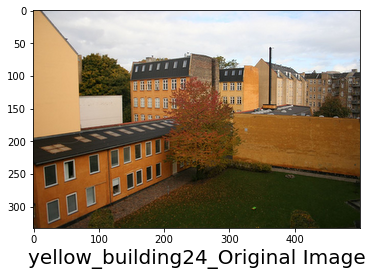

********* Predictions ***********


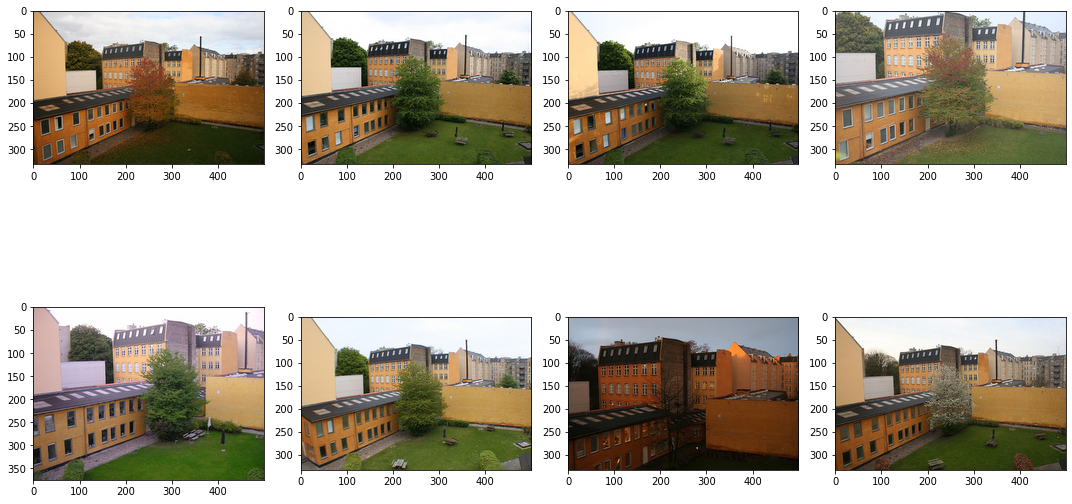

In [54]:
print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

# DEBUG

In [3]:
from tensorflow import keras

setup_dir_path = "setup_files"

model_resnet50_path = setup_dir_path + "/model_resnet50.sav"
model_neighbors_path = setup_dir_path + "/model_neighbors.sav"
filenames_index_path = setup_dir_path + "/filenames_index.sav"

model_resnet50 = keras.models.load_model(model_resnet50_path)
model_neighbors = pickle.load(open(model_neighbors_path, 'rb'))
filenames = pickle.load(open(filenames_index_path, 'rb'))

print("All loaded")

All loaded


In [4]:
img_size = 224
img_path = 'yellow_building24.jpg'

input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)

In [5]:
test_img_features = model_resnet50.predict(preprocessed_img, batch_size=1)
_, indices = model_neighbors.kneighbors(test_img_features)

(1, 8)


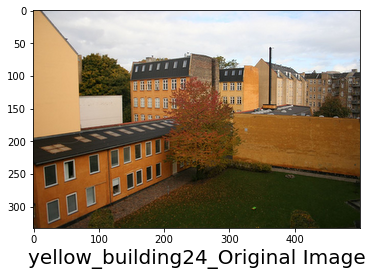

********* Predictions ***********


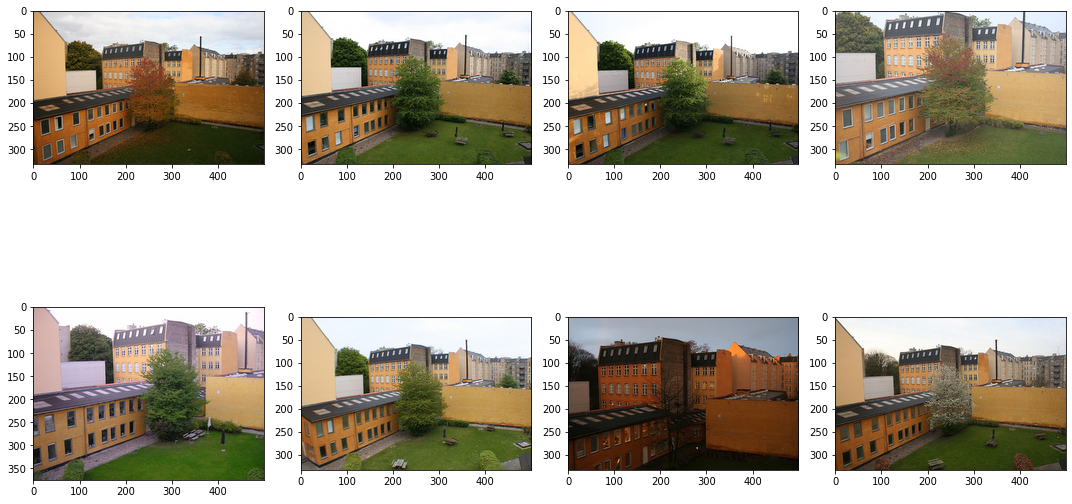

In [6]:
print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])